# AMAZON STOCKS

### importing libraries

In [1]:
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
from keras import models, layers
import yfinance as yf
import matplotlib.pyplot as plt

### Amazons's Stock Data

In [2]:
# AMZN -- Amazon's ticker
amazon = yf.Ticker('AMZN')

### data frame

In [3]:
history = amazon.history(period='max', interval='1d')

In [4]:
history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,72156000,0,0.0
1997-05-16,1.968750,1.979167,1.708333,1.729167,14700000,0,0.0
1997-05-19,1.760417,1.770833,1.625000,1.708333,6106800,0,0.0
1997-05-20,1.729167,1.750000,1.635417,1.635417,5467200,0,0.0
1997-05-21,1.635417,1.645833,1.375000,1.427083,18853200,0,0.0
...,...,...,...,...,...,...,...
2020-11-30,3208.479980,3228.389893,3125.550049,3168.040039,4063900,0,0.0
2020-12-01,3188.500000,3248.949951,3157.179932,3220.080078,4544400,0,0.0
2020-12-02,3221.649902,3232.000000,3173.260010,3203.530029,3129300,0,0.0


### function that uses TimeseriesGenerator class to generate the training set with dividends info

In [5]:
def generate_series(data, value_num):
    close = data['Close']
    dividends = data['Dividends']
    tsg = TimeseriesGenerator(close, close,
                              length=value_num,
                              batch_size=len(close))
    global_index = value_num
    i, t = tsg[0]
    has_dividends = np.zeros(len(i))
    for b_row in range(len(t)):
        assert(abs(t[b_row] - close[global_index]) <= 0.001)
        has_dividends[b_row] = dividends[global_index] > 0            
        global_index += 1
    return np.concatenate((i, np.transpose([has_dividends])),
                           axis=1), t

In [6]:
inputs, targets = generate_series(history, 4)

### performing MinMax normalization

In [7]:
h_min = history.min()
normalized_h = (history - h_min) / (history.max() - h_min)

In [8]:
inputs, targets = generate_series(normalized_h, 4)

### creates a neural network with a specified number of inputs

In [9]:
def create_model(n):
    m = models.Sequential()
    m.add(layers.Dense(64, activation='relu', input_shape=(n+1,)))
    m.add(layers.Dense(64, activation='relu'))
    m.add(layers.Dense(1))
    return m

### splitting data into test and train

In [10]:
train_inputs = inputs[:-1000]
val_inputs = inputs[-1000:]
train_targets = targets[:-1000]
val_targets = targets[-1000:]

### training the model

In [11]:
def select_inputs(data, start, end, epochs):
    models = {}
    for inputs in range(start, end+1):
#         print('Using {} inputs'.format(inputs))
        model_inputs, targets = generate_series(data, inputs)
        
        train_inputs = model_inputs[:-1000]
        val_inputs = model_inputs[-1000:]
        train_targets = targets[:-1000]
        val_targets = targets[-1000:]
        
        m = create_model(inputs)
#         print('Training')
        m.compile(optimizer='adam', loss='mse') 
        h = m.fit(train_inputs, train_targets,
                  epochs=epochs,
                  batch_size=32,
                  validation_data=(val_inputs, val_targets))
        model_info = {'model': m, 'history': h.history}
        models[inputs] = model_info
    return models


In [12]:
trained_models = select_inputs(normalized_h, 2, 10, 20)

Epoch 1/20
154/154 [==============================] - 1s 4ms/step - loss: 2.2330e-04 - val_loss: 0.0040
Epoch 2/20
154/154 [==============================] - 1s 3ms/step - loss: 2.3024e-06 - val_loss: 0.0033
Epoch 3/20
154/154 [==============================] - 1s 4ms/step - loss: 2.2383e-06 - val_loss: 0.0033
Epoch 4/20
154/154 [==============================] - 0s 3ms/step - loss: 2.2004e-06 - val_loss: 0.0033
Epoch 5/20
154/154 [==============================] - 1s 4ms/step - loss: 2.3766e-06 - val_loss: 0.0032
Epoch 6/20
154/154 [==============================] - 0s 3ms/step - loss: 2.4040e-06 - val_loss: 0.0033
Epoch 7/20
154/154 [==============================] - 1s 4ms/step - loss: 2.6072e-06 - val_loss: 0.0033
Epoch 8/20
154/154 [==============================] - 1s 4ms/step - loss: 2.3990e-06 - val_loss: 0.0036
Epoch 9/20
154/154 [==============================] - 1s 4ms/step - loss: 2.4487e-06 - val_loss: 0.0028
Epoch 10/20
154/154 [==============================] - 1s 4ms/st

In [13]:
# print(trained_models[2]['model'].predict(val_targets))
model = trained_models[2]['model']


### short summary

In [14]:
model_stats = {}
for k, v in trained_models.items():
    train_history = v['history']
    loss = train_history['loss'][-1]
    val_loss = train_history['val_loss'][-1]
    model_stats[k] = {'inputs': k, 'loss': loss, 'val_loss': val_loss}

In [15]:
model_stats

{2: {'inputs': 2,
  'loss': 2.7858116027346114e-06,
  'val_loss': 0.0025205567944794893},
 3: {'inputs': 3,
  'loss': 2.978063776026829e-06,
  'val_loss': 0.0027541921008378267},
 4: {'inputs': 4,
  'loss': 2.9612326670758193e-06,
  'val_loss': 0.0009634866146370769},
 5: {'inputs': 5,
  'loss': 2.8857186862296658e-06,
  'val_loss': 0.0028152992017567158},
 6: {'inputs': 6,
  'loss': 3.1847675927565433e-06,
  'val_loss': 0.0001810312387533486},
 7: {'inputs': 7,
  'loss': 2.934394842668553e-06,
  'val_loss': 0.00042816679342649877},
 8: {'inputs': 8,
  'loss': 3.2030536658567144e-06,
  'val_loss': 0.001275884686037898},
 9: {'inputs': 9,
  'loss': 3.469835064606741e-06,
  'val_loss': 0.0017034143675118685},
 10: {'inputs': 10,
  'loss': 3.293498821221874e-06,
  'val_loss': 0.0002788429846987128}}

### plotting val loss

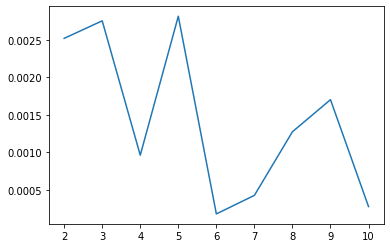

In [16]:
import matplotlib.pyplot as plt
val_loss = []
indices = []
for k, v in model_stats.items():
    indices.append(k)
    val_loss.append(v['val_loss'])
plt.plot(indices, val_loss)

### actual loss

In [17]:
vals = []
close_min = history['Close'].min()
close_max = history['Close'].max()
for k in model_stats:
    e = ((close_max - close_min) * model_stats[k]['val_loss'] + close_min)
    vals.append(e)
    print(k, e)

2 10.293535264567842
3 11.118280539841276
4 4.796993264513407
5 11.333991913066747
6 2.03488344288124
7 2.9072853253096858
8 5.899775362854281
9 7.408978275422682
10 2.3801641994247635
